**Mengupload dataset**

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving insurance.csv to insurance.csv


**Mengimport Module**

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import io
from plotly.offline import plot, iplot, init_notebook_mode
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

**Mengecek adanya missing value**

In [ ]:
ins = pd.read_csv(io.BytesIO(uploaded['insurance.csv']))
print("Terdapat {:,} observasi dan {} kolom di dataset.".format(ins.shape[0], ins.shape[1]))
print("Terdapat {} missing values di data.".format(ins.isna().sum().sum()))
ins['sex'] = ins['sex'].str.capitalize()
ins['smoker'] = ins['smoker'].apply(lambda x: 'Smoker' if x=='yes' else 'Non-Smoker')
ins['region'] = ins['region'].str.capitalize()

Terdapat 1,338 observasi dan 7 kolom di dataset.
Terdapat 0 missing values di data.


**Menunjukan ukuran dataset**

In [ ]:
ins.shape

(1338, 7)

**Menunjukan 10 data pertama dari dataset**

In [ ]:
ins.head(10)

,age,sex,bmi,children,smoker,region,charges
0,19,Female,27.900,0,Smoker,Southwest,16884.92400
1,18,Male,33.770,1,Non-Smoker,Southeast,1725.55230
2,28,Male,33.000,3,Non-Smoker,Southeast,4449.46200
3,33,Male,22.705,0,Non-Smoker,Northwest,21984.47061
4,32,Male,28.880,0,Non-Smoker,Northwest,3866.85520
5,31,Female,25.740,0,Non-Smoker,Southeast,3756.62160
6,46,Female,33.440,1,Non-Smoker,Southeast,8240.58960
7,37,Female,27.740,3,Non-Smoker,Northwest,7281.50560
8,37,Male,29.830,2,Non-Smoker,Northeast,6406.41070
9,60,Female,25.840,0,Non-Smoker,Northwest,28923.13692


**Menunjukan statistika deskriptif dari variabel numerik di dataset**

In [ ]:
ins.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


**Menunjukan statistika deskriptif dari variabel kategorik di dataset**

In [ ]:
ins.select_dtypes(include=['object']).describe()

,sex,smoker,region
count,1338,1338,1338
unique,2,2,4
top,Male,Non-Smoker,Southeast
freq,676,1064,364


**Menunjukan rata-rata jumlah klaim asuransi dari variabel kategorik**

In [ ]:
cat=ins.select_dtypes(include=['object']).columns.tolist()
for i in cat:
    obs=ins[i].value_counts()
    avg_claim=ins.groupby(i)["charges"].mean()
    display(pd.DataFrame({"Number of Policyholders":obs, "Average Claim Amount":avg_claim.map('${:,.2f}'.format)})\
            .sort_values('Number of Policyholders', ascending=False)\
            .style.set_caption("Variable: {}".format(i)))

,Number of Policyholders,Average Claim Amount
Male,676,"$13,956.75"
Female,662,"$12,569.58"


,Number of Policyholders,Average Claim Amount
Non-Smoker,1064,"$8,434.27"
Smoker,274,"$32,050.23"


,Number of Policyholders,Average Claim Amount
Southeast,364,"$14,735.41"
Northwest,325,"$12,417.58"
Southwest,325,"$12,346.94"
Northeast,324,"$13,406.38"


**Melakukan label encoder untuk variabel numerik**

In [ ]:
from sklearn.preprocessing import LabelEncoder
#sex
le = LabelEncoder()
le.fit(ins.sex.drop_duplicates()) 
ins.sex = le.transform(ins.sex)
# smoker or not
le.fit(ins.smoker.drop_duplicates()) 
ins.smoker = le.transform(ins.smoker)
#region
le.fit(ins.region.drop_duplicates()) 
ins.region = le.transform(ins.region)
ins.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520


**Menunjukan correlation matrix/heat map**

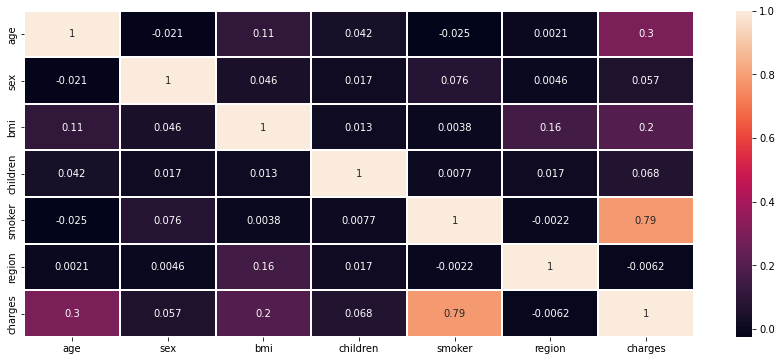

In [ ]:
heatmap=ins.corr()
ax= plt.figure(figsize=(15,6))
sns.heatmap(heatmap,linewidths=1,linecolor='white',annot=True)

**Membuat grafik distribusi jumlah klaim dengan status merokok**

In [ ]:
fig=px.histogram(ins, x='charges', color='smoker', opacity=0.7, barmode='overlay',
                 histnorm='probability density', marginal='box', 
                 title="Distribution of Insurance Costs by Smoking Status",
                 color_discrete_sequence=['#B14B51','#B7A294']) 
fig.update_layout(font_color="#303030", xaxis_title='Claim Amount, $',
                  yaxis=dict(title='Probability Density', gridcolor='#EAEAEA', zerolinecolor='#EAEAEA'),
                  legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1, title=""))
fig.update_xaxes(showgrid=False, zerolinecolor='#EAEAEA')
fig.show()

**Membuat grafik rata-rata jumlah klaim dengan usia dan status merokok**

In [ ]:
plot_df = ins.copy()
plot_df["Age_Group"]=['18 to 29 years' if i<30 else '30 to 44 years' if (i>=30)&(i<45) else 
                      '45 to 59 years' if (i>=45)&(i<60) else '60 and over' for i in ins['age']]
plot_df = plot_df.groupby(['Age_Group','smoker'])['charges'].mean()
plot_df = plot_df.rename('charges').reset_index().sort_values('smoker', ascending=True)
fig = px.bar(plot_df, x='Age_Group', y='charges', color='smoker', height=500, text='charges', 
             opacity=0.75, barmode='group', color_discrete_sequence=['#B7A294','#B14B51'],
             title="Average Insurance Costs by Age and Smoking Status")
fig.update_traces(texttemplate='$%{text:,.0f}', textposition='outside', 
                  marker_line=dict(width=1, color='#303030'))
fig.update_layout(font_color="#303030",bargroupgap=0.05, bargap=0.3, 
                  legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1, title=""),
                  xaxis=dict(title='Age',showgrid=False), 
                  yaxis=dict(title='Claim Amount, $', showgrid=False,zerolinecolor='#DBDBDB',
                             showline=True, linecolor='#DBDBDB', linewidth=2))
fig.show()

**Membuat grafik jumlah asuransi antar perokok dengan BMI**

In [ ]:
fig = px.scatter(ins, x='bmi', y='charges', color='smoker', size='charges',
                 title="Insurance costs increase with Body Mass Index among Smokers",
                 color_discrete_sequence=['#B14B51','#B7A294'],height=600)
fig.update_layout(legend=dict(title='',orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
                  font_color="#303030", xaxis=dict(title='Body Mass Index (BMI)',showgrid=False), 
                  yaxis=dict(title='Claim Amount, $',showgrid=False, zerolinecolor='#E5E5EA',
                             showline=True, linecolor='#E5E5EA', linewidth=2))
fig.show()

**Membuat grafik jumlah rata-rata klaim asuransi dengan wilayah dan status merokok**

In [ ]:
plot_df = ins.groupby(['region','sex','smoker'])['charges'].mean()
plot_df = plot_df.rename('charges').reset_index()
fig = px.bar(plot_df, x='region', y='charges', color='sex', height=800,
             title="Average Insurance Costs by Region and Smoking Status",
             color_discrete_map={'Female': '#BFC5DA','Male': '#5D6A92'}, 
             facet_row='smoker', text='charges', opacity=0.85, barmode='group')
fig.update_traces(texttemplate='$%{text:,.0f}', textposition='outside', 
                  marker_line=dict(width=1, color='#303030'))
fig.layout.yaxis2.update(matches=None)
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.update_xaxes(title="Region", row=1)
fig.update_yaxes(title="Claim Amount, $",  gridcolor='#E3E3E3', zeroline=True, zerolinewidth=2, 
                 showgrid=False, zerolinecolor='#E5E5EA',
                 showline=True, linecolor='#E5E5EA', linewidth=2)
fig.update_layout(font_color="#303030", paper_bgcolor="white", plot_bgcolor="white",
                  bargroupgap=0.05, bargap=0.2,
                  legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1, title=""))
fig.show()